# **Detecting Alzheimer’s with Enhanced Slice Selection & ViT**  
### *First Improvement Deliverable*

---

## **Group Members**
- **Sheraz Waseem** – *26100026*  
- **Umair Amir** – *26100148*  

---

## **Dataset: OASIS-2**  

The **OASIS-2** dataset is a longitudinal collection of brain MRI scans used to study aging and Alzheimer's Disease progression.  

**Key Details:**
- **Subjects:** 150 elderly individuals aged 60–96  
- **Scans:** Multiple T1-weighted scans per subject  
- **Labels:** Binary classification of *"Demented"* vs *"Nondemented"*  
- **Data Cleaning:** Filtered to include only clear dementia cases  

---

## **Model Components: SE Module + Pretrained ViT**  

Our approach integrates two core deep learning components:

### 1. **Slice Selector (SE Module)**  
A custom neural network module that learns to identify the most informative slices from 3D brain volumes.

**Key Features:**
- Attention mechanism using fully connected layers  
- Generates a learned weighting across the depth dimension  
- Selects top-k (`k=3`) most informative slices  
- Creates composite RGB images from weighted slice combinations  
- Adaptive to handle variable depth dimensions across scans  

### 2. **Vision Transformer (ViT)**  
We use a **pretrained ViT model** from Hugging Face:  
→ `google/vit-base-patch16-224-in21k`

**Key Features:**
- **Architecture:** `ViTForImageClassification`  
- **Input:** 224×224 RGB images (slice composites)  
- **Transformer:** 12 layers, 12 attention heads, hidden size 768  
- **Output:** Binary prediction (*"Nondemented"* vs *"Demented"*)  

---

## **Pipeline Overview**

### **1. Data Preprocessing**
- Raw `.hdr` and `.img` volumes are parsed using **NiBabel**  
- Volumes are normalized to `[0,1]` range  
- Full 3D volumes preserved and converted to tensors  

### **2. Dataset Construction**
- Subject IDs and labels are loaded from the OASIS-2 Excel sheet  
- Files are matched to subjects using folder name patterns  
- Custom **PyTorch Dataset** returns full volumes and binary labels  
- Train-test split (**80/20**) is performed with stratification by diagnosis  

### **3. SEViT Architecture**
- Two-stage architecture combining **Slice Selector** and **ViT**  
- Slice Selector processes full 3D volumes to create weighted 2D composites  
- ViT processes these composites for final classification  
- End-to-end training with both components optimized jointly  

### **4. Training**
- Optimization of the full architecture (SE + ViT)  
- Selective composite generation during both training and inference  
- **Optimizer:** AdamW  
  - Learning rate: `1e-5`  
  - Weight decay: `1e-4`  
- Training for **12 epochs** with **batch size 8**  
- Best model selected based on **F1 score**  

### **5. Analysis & Visualization**
- Frequency distribution of selected slices across validation set  
- **Bar plots** showing which slice indices were most informative  
- Tracking of **attention weights** to understand model focus  
- Visualization of how the model's slice preferences evolve  
 


## Connecting to Google Drive to Access Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extracting dataset zip file

In [3]:
import tarfile

file_path = '/content/drive/MyDrive/OasisDataset2/OAS2_RAW_PART1.tar.gz'
extract_path = '/content/oasis_data'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
import os, shutil, pandas as pd

XL_PATH   = "/content/drive/MyDrive/OasisDataset2/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
DATA_ROOT = "/content/oasis_data/OAS2_RAW_PART1"
TRASH_DIR = "/content/converted_scans_backup"  

df = pd.read_excel(XL_PATH)

converted_ids = df.loc[df["Group"].eq("Converted"), "MRI ID"].unique().tolist()
print(f"Found {len(converted_ids)} converted visits")

os.makedirs(TRASH_DIR, exist_ok=True)

for mri_id in converted_ids:
    src = os.path.join(DATA_ROOT, mri_id)  
    if not os.path.isdir(src):
        print(f"[WARN] {src} not found, skipping")
        continue

    dst = os.path.join(TRASH_DIR, mri_id)
    shutil.move(src, dst)                 

    print(f"✓ removed {mri_id}")

print("Done!")

Found 37 converted visits
✓ removed OAS2_0018_MR1
✓ removed OAS2_0018_MR3
✓ removed OAS2_0018_MR4
✓ removed OAS2_0020_MR1
✓ removed OAS2_0020_MR2
✓ removed OAS2_0020_MR3
✓ removed OAS2_0031_MR1
✓ removed OAS2_0031_MR2
✓ removed OAS2_0031_MR3
✓ removed OAS2_0041_MR1
✓ removed OAS2_0041_MR2
✓ removed OAS2_0041_MR3
✓ removed OAS2_0054_MR1
✓ removed OAS2_0054_MR2
✓ removed OAS2_0092_MR1
✓ removed OAS2_0092_MR2
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR3 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR3 no

In [ ]:

!pip -q install -U "transformers>=4.41.0" "huggingface_hub>=0.23.0" accelerate \
                nibabel pandas scikit-learn tqdm pillow


import os, json, numpy as np, pandas as pd, nibabel as nib, torch
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    ViTConfig,
    ViTForImageClassification,
    ViTImageProcessor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
from sklearn.metrics import accuracy_score, f1_score

EXCEL = "/content/drive/MyDrive/OasisDataset2/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
ROOT  = "/content/oasis_data/OAS2_RAW_PART1"         
CFG   = "/content/vit_2class.json"

cfg_json = {
    "_name_or_path": "google/vit-base-patch16-224-in21k",
    "architectures": ["ViTForImageClassification"],
    "image_size": 224,
    "patch_size": 16,
    "hidden_size": 768,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "intermediate_size": 3072,
    "hidden_act": "gelu",
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-12,
    "qkv_bias": True,
    "num_channels": 3,
    "id2label": {"0": "Nondemented", "1": "Demented"},
    "label2id": {"Nondemented": 0, "Demented": 1},
}
with open(CFG, "w") as f: json.dump(cfg_json, f)


def three_views_rgb(hdr_path):
    """Return a PIL RGB image (224 × 224) built from the middle axial,
    coronal, sagittal slices. Handles 3-D or 4-D NIfTI volumes."""
    vol = nib.load(hdr_path).get_fdata().astype(np.float32)

    vol = np.squeeze(vol)
    if vol.ndim == 4:                       
        vol = vol[..., 0]
    if vol.ndim != 3:
        raise ValueError(f"Unexpected volume shape {vol.shape}")

    cx, cy, cz = np.array(vol.shape) // 2
    slices = [vol[cx, :, :], vol[:, cy, :], vol[:, :, cz]]

    def to_pil(slice2d):
        s_min, s_max = slice2d.min(), slice2d.max()
        if s_max > s_min:
            sl = ((slice2d - s_min) / (s_max - s_min) * 255).astype(np.uint8)
        else:
            sl = np.zeros_like(slice2d, dtype=np.uint8)
        return Image.fromarray(sl).resize((224, 224), Image.BILINEAR)

    triplet = [np.array(to_pil(s)) for s in slices]     
    stacked = np.stack(triplet, axis=-1)              
    return Image.fromarray(stacked)


df = pd.read_excel(EXCEL)
df = df[df["Group"].isin(["Nondemented", "Demented"])][["MRI ID", "Group"]].drop_duplicates()

records = []
for mri_id, label in tqdm(df.values, total=len(df)):
    raw_dir = os.path.join(ROOT, mri_id, "RAW")
    if not os.path.isdir(raw_dir):
        continue
    hdrs = [f for f in sorted(os.listdir(raw_dir)) if f.endswith(".hdr")]
    if hdrs:
        records.append({"hdr_path": os.path.join(raw_dir, hdrs[0]), "label": label})

clean_df = pd.DataFrame(records)
print("Usable scans:", len(clean_df))




label2id = {"Nondemented": 0, "Demented": 1}
to_tensor = T.ToTensor()

class OasisVolumeDataset(Dataset):
    def __init__(self, df_subset):
        self.df = df_subset.reset_index(drop=True)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row  = self.df.iloc[idx]
        vol  = nib.load(row.hdr_path).get_fdata().astype(np.float32)
        vol  = np.squeeze(vol)
        if vol.ndim == 4:
            vol = vol[..., 0]                 

        rng = np.ptp(vol)
        if rng > 0:
            vol = (vol - vol.min()) / rng
        else:
            vol = np.zeros_like(vol)

        vol_t = torch.stack([to_tensor(slc) for slc in vol], dim=0)
        label = torch.tensor(label2id[row.label])
        return {"volume": vol_t, "labels": label}


def volume_depth(path):
    shape = np.squeeze(nib.load(path).shape)
    return shape[0] if len(shape) >= 3 else 0

max_depth = max(volume_depth(p) for p in clean_df.hdr_path)
print("max depth =", max_depth)




class SliceSelector(nn.Module):
    def __init__(self, depth, reduction=4, k=3):
        super().__init__()
        self.k = k
        self.last_indices = None          
        self.fc = nn.Sequential(
            nn.Linear(depth, depth // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(depth // reduction, depth * k)
        )
        self.resize = T.Resize((224, 224), interpolation=Image.BILINEAR)

    def forward(self, x):                 
        B, D, _, H, W = x.shape
        x_flat = x.mean(dim=[3,4]).squeeze(2)        
        attn   = self.fc(x_flat).view(B, self.k, D)  
        weights= F.softmax(attn, dim=-1)             

        self.last_indices = torch.argmax(weights, dim=-1).cpu()   

        comps = torch.einsum("bkd,bdhw->bkhw", weights, x.squeeze(2))
        comps = self.resize(comps)           
        return comps      


class SEViT(nn.Module):
    def __init__(self, vit_model, depth):
        super().__init__()
        self.selector = SliceSelector(depth=depth, k=3)
        self.vit      = vit_model

    def forward(self, volume, labels=None):           
        rgb = self.selector(volume)                  
        outputs = self.vit(pixel_values=rgb, labels=labels)
        return outputs

train_df, val_df = train_test_split(
    clean_df, test_size=0.2, stratify=clean_df["label"], random_state=42
)
print(len(train_df), "train |", len(val_df), "val")


config = ViTConfig.from_json_file(CFG)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

train_set = OasisVolumeDataset(train_df)
val_set   = OasisVolumeDataset(val_df)

max_depth = max(item["volume"].shape[0] for item in train_set)

vit = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        config=config, ignore_mismatched_sizes=True)

model = SEViT(vit_model=vit, depth=max_depth)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1":       f1_score(labels, preds, average="weighted"),
    }

args = TrainingArguments(
    output_dir                = "/content/vit_oasis_ckpts",
    per_device_train_batch_size= 8,
    per_device_eval_batch_size = 8,
    num_train_epochs          = 12,
    learning_rate             = 1e-5,
    weight_decay              = 1e-4,
    eval_strategy       = "epoch",
    save_strategy             = "epoch",
    load_best_model_at_end    = True,
    metric_for_best_model     = "f1",
    seed                      = 42,
    logging_strategy          = "epoch",
)

trainer = Trainer(
    model           = model,
    args            = args,
    data_collator   = DefaultDataCollator(),
    train_dataset   = train_set,
    eval_dataset    = val_set,
    compute_metrics = compute_metrics,
)

trainer.train()




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not c

  0%|          | 0/336 [00:00<?, ?it/s]

Usable scans: 193
max depth = 256
154 train | 39 val


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: umair-amir (umair-amir-lums) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686000,0.661096,0.589744,0.437552
2,0.629000,0.650150,0.666667,0.589355
3,0.591900,0.639985,0.769231,0.759175
4,0.547000,0.612527,0.743590,0.735531
5,0.493000,0.608398,0.717949,0.671294
6,0.436100,0.599471,0.743590,0.728797
7,0.408100,0.649110,0.641026,0.642443
8,0.352500,0.608795,0.743590,0.740385
9,0.300500,0.598774,0.717949,0.705659
10,0.285900,0.643095,0.615385,0.618451


TrainOutput(global_step=240, training_loss=0.43633167346318563, metrics={'train_runtime': 1074.5347, 'train_samples_per_second': 1.72, 'train_steps_per_second': 0.223, 'total_flos': 0.0, 'train_loss': 0.43633167346318563, 'epoch': 12.0})

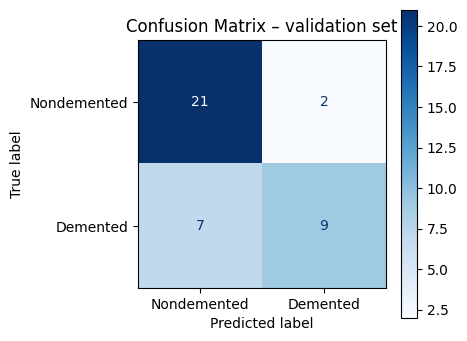

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_out = trainer.predict(val_set)
y_true   = pred_out.label_ids
y_pred   = np.argmax(pred_out.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Nondemented", "Demented"])

fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - validation set")
plt.show()

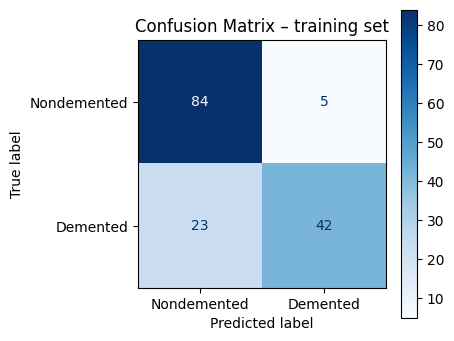

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_out = trainer.predict(train_set)
y_true   = pred_out.label_ids
y_pred   = np.argmax(pred_out.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Nondemented", "Demented"])

fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - training set")
plt.show()

Chosen slice indices per validation scan:
[199, 138, 165]
[248, 138, 165]
[248, 138, 165]
[199, 138, 165]
[199, 138, 165]
[199, 138, 165]
[248, 138, 165]
[199, 138, 165]
[248, 138, 165]
[248, 138, 165]
[199, 138, 165]
[154, 138, 165]
[199, 138, 165]
[57, 138, 165]
[199, 138, 165]
[106, 138, 165]
[106, 138, 165]
[248, 138, 165]
[199, 138, 165]
[106, 138, 165]
[57, 138, 165]
[199, 138, 165]
[199, 138, 165]
[106, 138, 165]
[199, 138, 165]
[199, 138, 165]
[248, 138, 165]
[199, 138, 165]
[199, 138, 165]
[199, 138, 165]
[199, 138, 165]
[248, 138, 165]
[248, 138, 165]
[57, 138, 165]
[199, 93, 165]
[199, 138, 165]
[248, 138, 165]
[248, 138, 165]
[199, 138, 165]


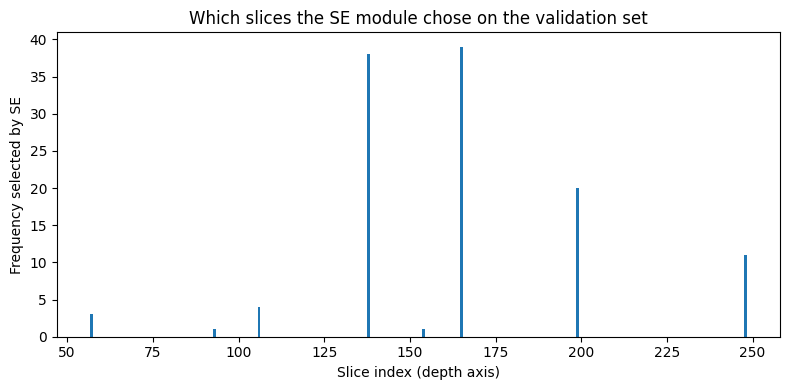

In [ ]:
import collections, matplotlib.pyplot as plt

model.eval()
freq = collections.Counter()

print("Chosen slice indices per validation scan:")
with torch.no_grad():
    for batch in torch.utils.data.DataLoader(val_set, batch_size=1):
        out = model(volume=batch["volume"].to(model.vit.device))  
        picks = model.selector.last_indices.squeeze(0).tolist()    
        print(picks)
        freq.update(picks)

slices, counts = zip(*sorted(freq.items()))
plt.figure(figsize=(8,4))
plt.bar(slices, counts)
plt.xlabel("Slice index (depth axis)")
plt.ylabel("Frequency selected by SE")
plt.title("Which slices the SE module chose on the validation set")
plt.tight_layout()
plt.show()